In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from concurrent.futures import ThreadPoolExecutor

In [2]:
train_data = pd.read_csv("C:/Users/syuan/Desktop/ML/final project/playground-series-s4e12/train.csv")
test_data = pd.read_csv("C:/Users/syuan/Desktop/ML/final project/playground-series-s4e12/test.csv")

In [3]:
train_data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
train_data.shape  #1200000筆樣本數

(1200000, 21)

In [5]:
test_data.shape  #800000筆樣本數

(800000, 20)

In [6]:
train_data.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [7]:
test_data.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')

## Data Preprocessing

In [9]:
print(f"Premium Amount 欄位的缺失值數量: {train_data['Premium Amount'].isna().sum()}")

Premium Amount 欄位的缺失值數量: 0


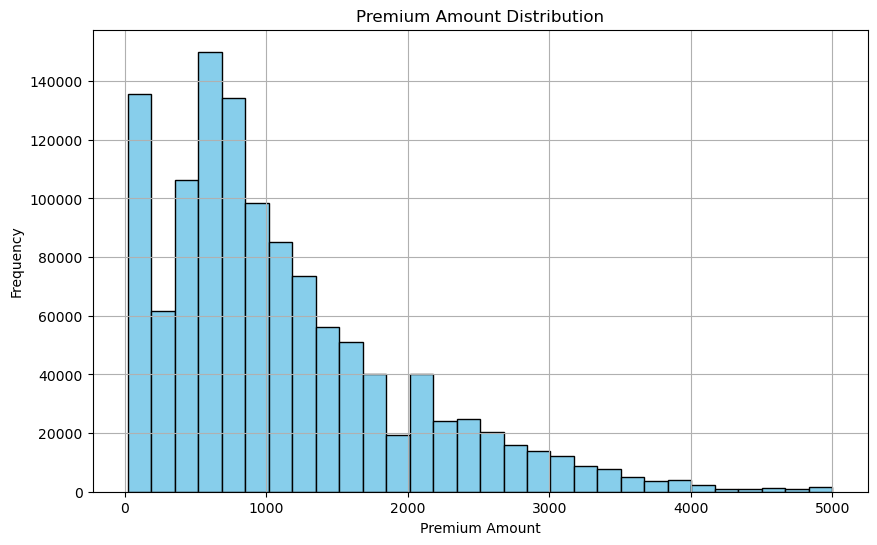

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(train_data['Premium Amount'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Premium Amount Distribution')
plt.xlabel('Premium Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From this histogram, it is evident that the distribution of Premium Amount is right-skewed. When performing regression analysis, it is often beneficial to consider data transformation. This can help stabilize variance, reduce the model's sensitivity to extreme values, and improve the performance of the regression model.

Applying a logarithmic transformation to Premium Amount before regression modeling can make the data distribution closer to normal, which can enhance the model's fit and effectiveness.

In [12]:
train_data['Premium Amount'].min()

20.0

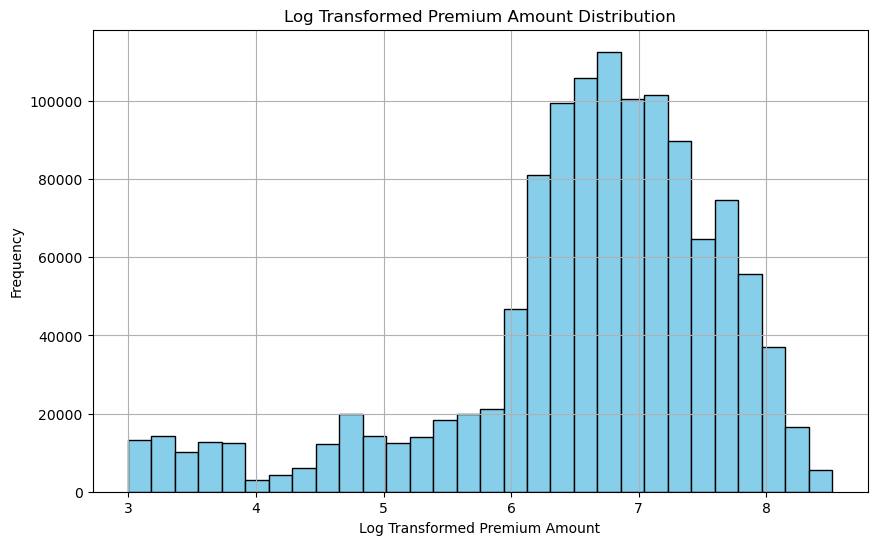

In [13]:
# 進行 log 轉換
train_data['Log Premium Amount'] = np.log(train_data['Premium Amount'])

# 繪製轉換後的 Premium Amount 分佈
plt.figure(figsize=(10, 6))
plt.hist(train_data['Log Premium Amount'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Log Transformed Premium Amount Distribution')
plt.xlabel('Log Transformed Premium Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

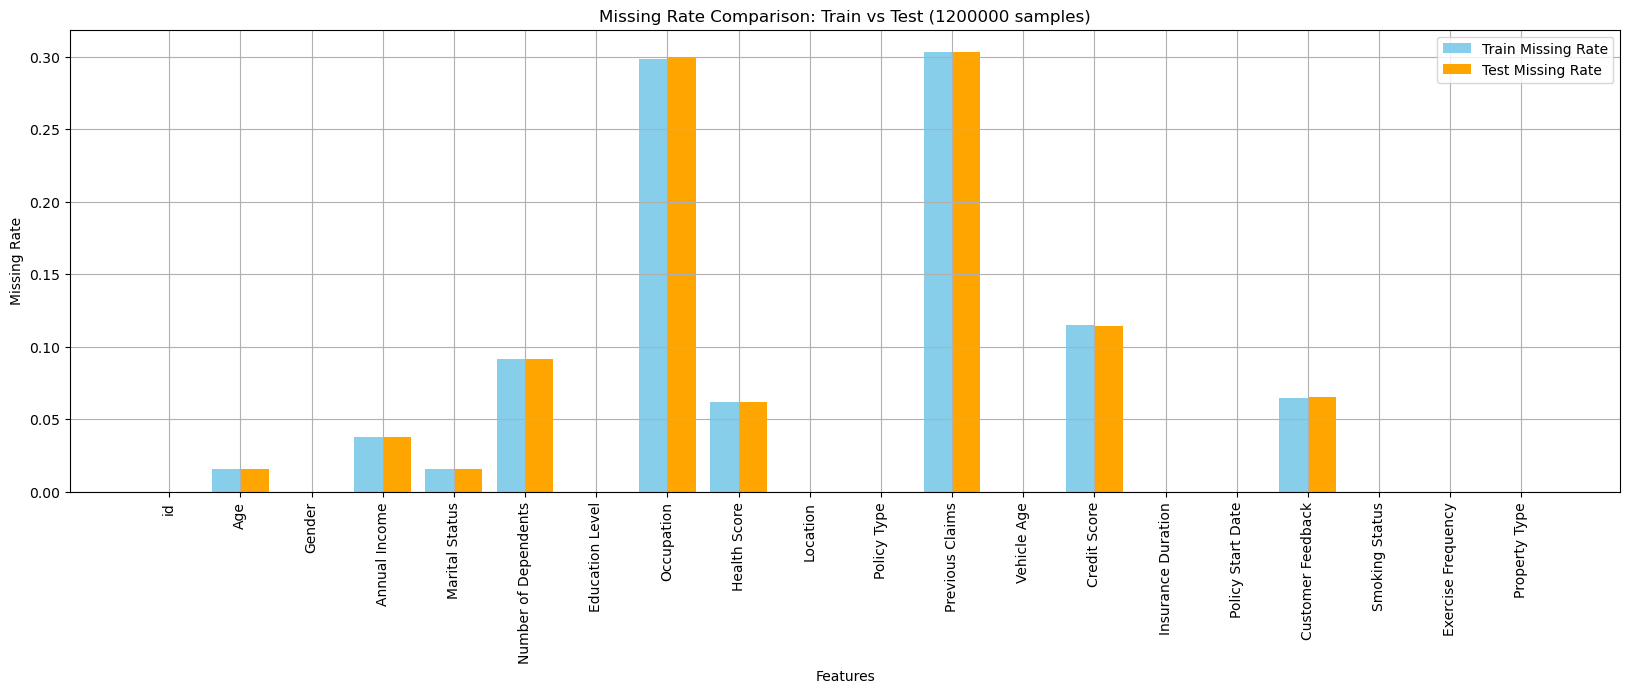

In [14]:
# 確保訓練資料和測試資料具有相同的特徵
common_columns = train_data.columns.intersection(test_data.columns)

# 計算缺失值比例，僅針對共同的特徵
train_missing_ratios = train_data[common_columns].isna().sum() / len(train_data)
test_missing_ratios = test_data[common_columns].isna().sum() / len(test_data)

# 設置x軸位置
x = range(len(train_missing_ratios))

# 繪製長條圖，顯示訓練資料和測試資料的缺失值比例
plt.figure(figsize=(20, 6))
plt.bar(x, train_missing_ratios.values, width=0.4, label='Train Missing Rate', color="skyblue", align='center')
plt.bar([i + 0.4 for i in x], test_missing_ratios.values, width=0.4, label='Test Missing Rate', color="orange", align='center')

# 設定x軸標籤
plt.xticks([i + 0.2 for i in x], train_missing_ratios.index, rotation=90)

# 設定圖表標題與標籤
plt.title(f'Missing Rate Comparison: Train vs Test ({len(train_data)} samples)')
plt.xlabel('Features')
plt.ylabel('Missing Rate')
plt.grid(True)

# 顯示圖例
plt.legend()
plt.show()

In [15]:
# 定義連續型&離散型特徵
continuous_cols = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
discrete_cols = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 
                 'Location', 'Policy Type', 'Previous Claims', 'Customer Feedback', 
                 'Smoking Status', 'Exercise Frequency', 'Property Type']

In [16]:
# 訓練資料與測試資料合併，便於處理
data_combined = pd.concat([train_data, test_data], keys=['train', 'test'])

# 使用中位數填補
imputer_continuous = SimpleImputer(strategy='median')
data_combined[continuous_cols] = imputer_continuous.fit_transform(data_combined[continuous_cols])

# 離散型特徵處理（將缺失值設為新類別 "Missing"）
# 將缺失值填補為 'Missing'
for col in discrete_cols:
    data_combined[col] = data_combined[col].fillna('Missing')


# 提取年份
data_combined['Policy Start Date'] = pd.to_datetime(data_combined['Policy Start Date'])
data_combined['Policy Start Year'] = data_combined['Policy Start Date'].dt.year
continuous_cols.append('Policy Start Year')

# 提取月份
data_combined['Policy Start Date'] = pd.to_datetime(data_combined['Policy Start Date'])
data_combined['Policy Start Month'] = data_combined['Policy Start Date'].dt.month
continuous_cols.append('Policy Start Month')

# 轉換日期並提取月初、月中、月底分類
data_combined['Policy Start Date'] = pd.to_datetime(data_combined['Policy Start Date'])
data_combined['Policy Start Period'] = data_combined['Policy Start Date'].dt.day.apply(
    lambda day: 'Early Month' if day <= 10 else 'Mid Month' if day <= 20 else 'Late Month'
)
discrete_cols.append('Policy Start Period')

<Figure size 1000x600 with 0 Axes>

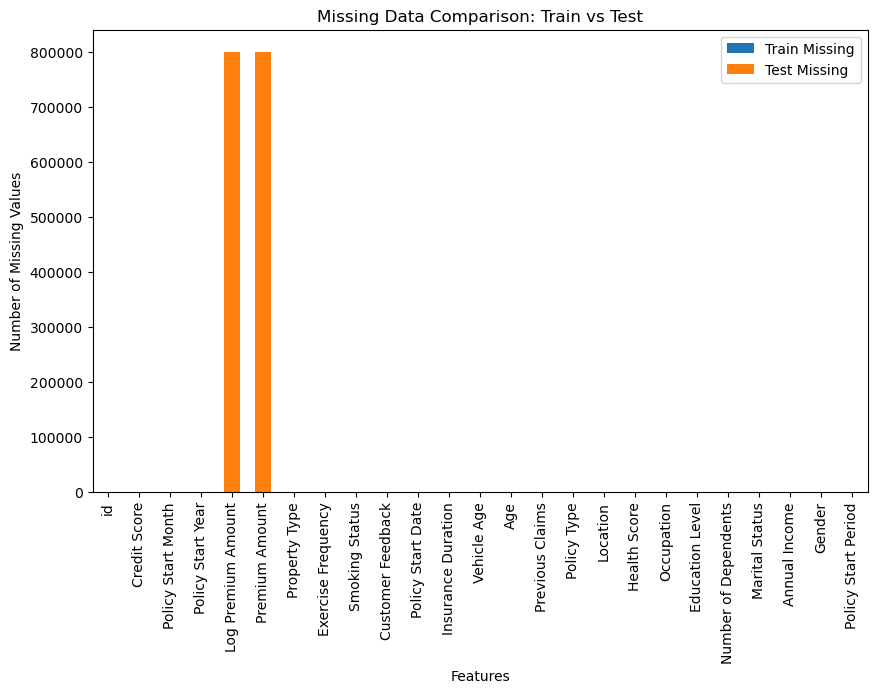

In [17]:
# 分離訓練資料與測試資料
train_data_cleaned = data_combined.xs('train')
test_data_cleaned = data_combined.xs('test')

# 確認填補情況
train_missing = train_data_cleaned.isnull().sum()
test_missing = test_data_cleaned.isnull().sum()

# 合併兩者，便於視覺化比較
missing_data = pd.DataFrame({
    'Train Missing': train_missing,
    'Test Missing': test_missing
}).sort_values(by='Train Missing', ascending=False)

# 可視化缺失值情況
plt.figure(figsize=(10, 6))
missing_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Missing Data Comparison: Train vs Test')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=90)
plt.show()

In [18]:
del train_data, test_data, data_combined, train_missing, test_missing

### Split data

In [20]:
X_train = train_data_cleaned.drop(columns=['id', 'Log Premium Amount', 'Premium Amount'])
y_train= train_data_cleaned['Log Premium Amount'] 
X_test = test_data_cleaned

In [21]:
del train_data_cleaned, test_data_cleaned

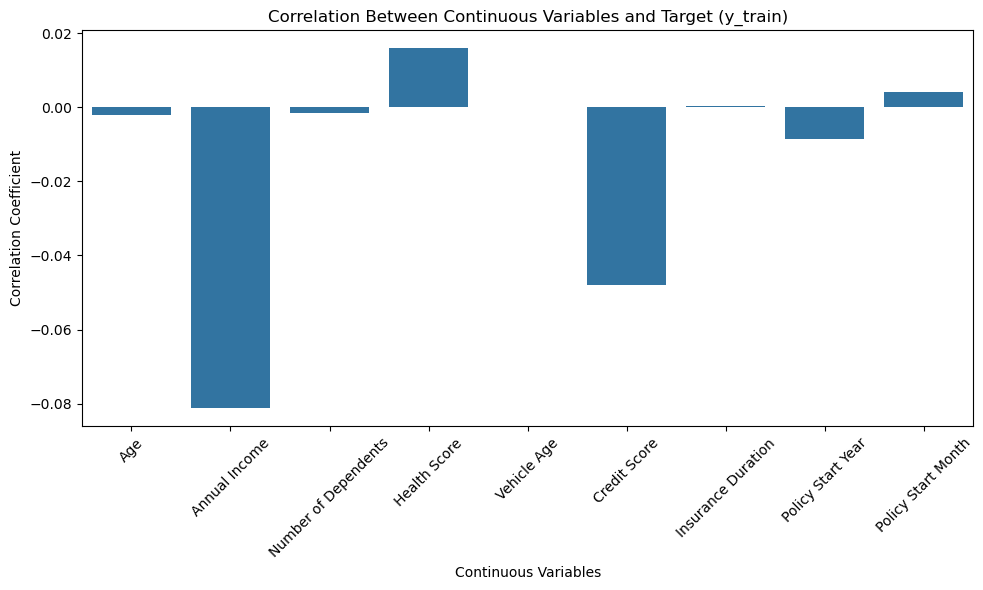

In [22]:
data_continuous = pd.concat([X_train[continuous_cols], y_train], axis=1)

# 計算相關係數矩陣
correlation_matrix = data_continuous.corr()

# 只保留連續變數與 y_train 的相關係數
target_corr = correlation_matrix.loc[continuous_cols, y_train.name]

# 繪製相關係數圖
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.title("Correlation Between Continuous Variables and Target (y_train)")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Continuous Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# 提取連續型特徵
X_train_continuous = X_train[continuous_cols]
scaler = Normalizer()
X_train_continuous = scaler.fit_transform(X_train_continuous)
X_train_continuous = pd.DataFrame(X_train_continuous, columns=continuous_cols)

In [26]:
X_train_discrete = X_train[discrete_cols]
X_train_discrete_encoded = pd.get_dummies(X_train_discrete, drop_first=True)

# 合併連續型特徵和編碼後的離散型特徵
X_train_continuous = X_train_continuous.reset_index(drop=True)
X_train_discrete_encoded = X_train_discrete_encoded.reset_index(drop=True)

# 合併資料
X_train_processed = pd.concat([X_train_continuous, X_train_discrete_encoded], axis=1)

In [50]:
# 建立線性回歸模型
model = LinearRegression()

# 訓練模型
model.fit(X_train_processed, y_train)

# 預測測試集
y_pred = model.predict(X_train_processed)

# 計算模型表現
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
#mse = mean_squared_error(np.exp(y_train), np.exp(y_pred))
#r2 = r2_score(np.exp(y_train), np.exp(y_pred))

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 1.2072
R-squared: 0.0057


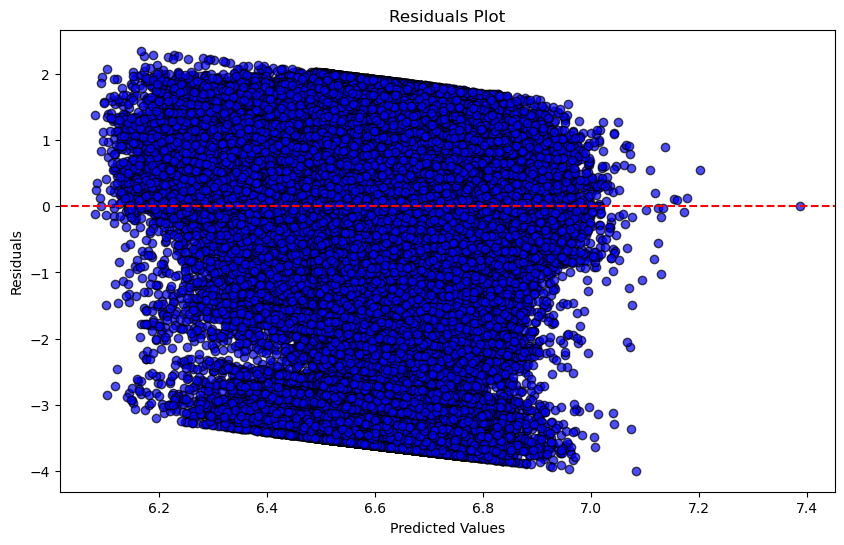

In [34]:
# 計算殘差
residuals = y_train - y_pred

# 畫出殘差圖
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### test data

In [36]:
# 提取連續型特徵
X_test_continuous = X_test[continuous_cols]
scaler = Normalizer()
X_test_continuous = scaler.fit_transform(X_test_continuous)
X_test_continuous = pd.DataFrame(X_test_continuous, columns=continuous_cols)

# 確保驗證集的離散型特徵欄位與訓練集一致，並移除訓練集中不存在的欄位
X_test_discrete = X_test[discrete_cols]
X_test_discrete_encoded = pd.get_dummies(X_test_discrete, drop_first=True)
X_test_discrete_encoded = X_test_discrete_encoded.reindex(columns=X_train_discrete_encoded.columns, fill_value=0)

# 合併連續型特徵和編碼後的離散型特徵
X_test_continuous = X_test_continuous.reset_index(drop=True)
X_test_discrete_encoded = X_test_discrete_encoded.reset_index(drop=True)
X_test_processed = pd.concat([X_test_continuous, X_test_discrete_encoded], axis=1)

In [38]:
# 初始化空的 DataFrame 用於儲存預測結果
predictions_test_df = pd.DataFrame()

# 假設 X_test 中有 'id' 欄位，這裡用來保存每個樣本的 id
id_column = X_test['id']  # 請根據實際的列名修改 'id' 欄位名稱

# 假設模型名稱為 model（請根據實際的變數名稱修改）
y_pred_test = np.exp(model.predict(X_test_processed))  # 預測結果

# 將 id 和預測結果儲存到 predictions_test_df
predictions_test_df = pd.DataFrame({
    'id': id_column,
    'prediction': y_pred_test
})

In [40]:
# 重置索引，並確保資料整齊
predictions_test_df = predictions_test_df.reset_index(drop=True)

# 依照 'id' 排列
predictions_test_df = predictions_test_df.sort_values(by='id')

# 輸出最終的預測結果
print(predictions_test_df)

             id  prediction
0       1200000  875.361698
1       1200001  669.434032
2       1200002  697.529885
3       1200003  693.147303
4       1200004  712.993043
...         ...         ...
799995  1999995  674.936382
799996  1999996  726.628976
799997  1999997  691.902158
799998  1999998  731.160952
799999  1999999  686.195453

[800000 rows x 2 columns]


In [42]:
sample_submission = pd.read_csv("C:/Users/syuan/Desktop/ML/final project/playground-series-s4e12/sample_submission.csv")

# 確保 sample_submission 中有 'id' 和預測結果欄位
# 假設 predictions_test_df 中的 'id' 和 'prediction' 欄位符合要求
sample_submission['Premium Amount'] = predictions_test_df['prediction']

# 將結果寫回到 sample_submission.csv，覆蓋原有的內容
sample_submission.to_csv("C:/Users/syuan/Desktop/ML/final project/playground-series-s4e12/sample_submission_linear_未分群.csv", index=False)